<a href="https://colab.research.google.com/github/ayush572/CNN_KNN_XAI/blob/main/KNN_Classification_inceptionV3_with_GradCAM_and_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ayushdg1
Your Kaggle Key: ··········


100%|██████████| 1.98G/1.98G [00:22<00:00, 92.7MB/s]


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
categories = os.listdir("/content/landuse-scene-classification/images")
image_dir = "/content/landuse-scene-classification/images"

In [ ]:
categories

['runway',
 'storagetanks',
 'forest',
 'freeway',
 'airplane',
 'mediumresidential',
 'beach',
 'golfcourse',
 'agricultural',
 'intersection',
 'baseballdiamond',
 'sparseresidential',
 'buildings',
 'chaparral',
 'overpass',
 'tenniscourt',
 'harbor',
 'parkinglot',
 'river',
 'mobilehomepark',
 'denseresidential']

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import os
from google.colab import drive
drive.mount('/content/drive')

# Set the path to the directory on Google Drive where you want to save the features
drive_path = '/content/drive/My Drive/CNN_KNN_Images_Features/'


# Set the paths to your image directories
image_dir = "/content/landuse-scene-classification/images"
train_test_val_dir = "/content/landuse-scene-classification/images_train_test_val"

# Load the InceptionV3 model
inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Prepare the image data from the "images" directory
image_size = (256, 256)  # InceptionV3 input size

# Use the InceptionV3 preprocessing function
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]
)

# Load the images from the "images" directory with data augmentation
image_data_images = datagen.flow_from_directory(image_dir, target_size=image_size, batch_size=32, class_mode="categorical")

# Prepare the image data from the "images_train_test_val" directory
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Define the subdirectories for "train," "test," and "validation"
train_dir = os.path.join(train_test_val_dir, "train")
test_dir = os.path.join(train_test_val_dir, "test")
validation_dir = os.path.join(train_test_val_dir, "validation")

# Load the training data from "train" directory
image_data_train = datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=32, class_mode="categorical")

# Load the testing data from "test" directory
image_data_test = datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=32, class_mode="categorical")

# Load the validation data from "validation" directory
image_data_val = datagen.flow_from_directory(validation_dir, target_size=image_size, batch_size=32, class_mode="categorical")

# Extract features from the InceptionV3 model
def extract_features(model, data_generator):
    features = []
    labels = []
    for _ in range(len(data_generator)):
        images, labels_batch = data_generator.next()
        features_batch = model.predict(images)
        features.append(features_batch)
        labels.append(labels_batch)
    return np.concatenate(features), np.concatenate(labels)

X_train_features, y_train_features = extract_features(inception_v3_model, image_data_train)
X_val_features, y_val_features = extract_features(inception_v3_model, image_data_val)
X_test_features, y_test_features = extract_features(inception_v3_model, image_data_test)

# Save the extracted features and labels to Google Drive
np.save(os.path.join(drive_path, "X_train_features_new.npy"), X_train_features)
np.save(os.path.join(drive_path, "y_train_features_new.npy"), y_train_features)
np.save(os.path.join(drive_path, "X_val_features_new.npy"), X_val_features)
np.save(os.path.join(drive_path, "y_val_features_new.npy"), y_val_features)
np.save(os.path.join(drive_path, "X_test_features_new.npy"), X_test_features)
np.save(os.path.join(drive_path, "y_test_features_new.npy"), y_test_features)

Mounted at /content/drive
87910968/87910968 [==============================] - 0s 0us/step
Found 10500 images belonging to 21 classes.
Found 7350 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
1/1 [==============================] - 3s 3s/step


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Load the saved features
X_train_features = np.load(os.path.join(drive_path, "X_train_features_new.npy"))
y_train_features = np.load(os.path.join(drive_path, "y_train_features_new.npy"))
X_test_features = np.load(os.path.join(drive_path, "X_test_features_new.npy"))
y_test_features = np.load(os.path.join(drive_path, "y_test_features_new.npy"))

# Reshape the loaded features from 4D to 2D
X_train_features_2D = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_2D = X_test_features.reshape(X_test_features.shape[0], -1)

# Create a pipeline with PCA, scaling, and KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the features
    ('pca', PCA(n_components=100)),  # Apply PCA for dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=11))  # KNN classifier
])

# Define a parameter grid for hyperparameter tuning
param_grid_new = {
    'pca__n_components': [50, 100, 150, 200, 250, 300],  # Number of principal components
    'knn__n_neighbors': [3, 5, 7, 9, 11]  # Number of neighbors
}

# Create a GridSearchCV object for hyperparameter tuning
grid_search_new = GridSearchCV(pipeline, param_grid_new, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search_new.fit(X_train_features_2D, np.argmax(y_train_features, axis=1))

# Get the best hyperparameters
best_params_new = grid_search_new.best_params_
print("Best Hyperparameters:", best_params_new)

# Save the best_params to a file
params_save_path = '/content/drive/My Drive/CNN_KNN_best_params/best_params_new.txt'
with open(params_save_path, 'w') as file:
    file.write(str(best_params_new))

# Use the best model for predictions
best_model_new = grid_search_new.best_estimator_
y_pred = best_model_new.predict(X_test_features_2D)

# Calculate accuracy
accuracy = np.mean(y_pred == np.argmax(y_test_features, axis=1))
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Save the best model to Google Drive
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
joblib.dump(best_model_new, model_save_path)

Best Hyperparameters: {'knn__n_neighbors': 11, 'pca__n_components': 100}
Accuracy: 79.43%


['/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib']

In [ ]:
# Load the InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Display the summary of the InceptionV3 model
inception_model.summary()

# Alternatively, print the names of all layers in the InceptionV3 model
for layer in inception_model.layers:
    print(layer.name)


87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [ ]:
print([layer.name for layer in inception_v3_model.layers])


['input_15', 'conv2d_1316', 'batch_normalization_1316', 'activation_1316', 'conv2d_1317', 'batch_normalization_1317', 'activation_1317', 'conv2d_1318', 'batch_normalization_1318', 'activation_1318', 'max_pooling2d_56', 'conv2d_1319', 'batch_normalization_1319', 'activation_1319', 'conv2d_1320', 'batch_normalization_1320', 'activation_1320', 'max_pooling2d_57', 'conv2d_1324', 'batch_normalization_1324', 'activation_1324', 'conv2d_1322', 'conv2d_1325', 'batch_normalization_1322', 'batch_normalization_1325', 'activation_1322', 'activation_1325', 'average_pooling2d_126', 'conv2d_1321', 'conv2d_1323', 'conv2d_1326', 'conv2d_1327', 'batch_normalization_1321', 'batch_normalization_1323', 'batch_normalization_1326', 'batch_normalization_1327', 'activation_1321', 'activation_1323', 'activation_1326', 'activation_1327', 'mixed0', 'conv2d_1331', 'batch_normalization_1331', 'activation_1331', 'conv2d_1329', 'conv2d_1332', 'batch_normalization_1329', 'batch_normalization_1332', 'activation_1329', '

In [ ]:
from google.colab import drive
import joblib

# Mount Google Drive to Colab
drive.mount('/content/drive')

# Replace 'your_model_path' with the path to your model file in Google Drive
model_path = '/content/drive/MyDrive/CNN_KNN_best_model/best_model_new.joblib'

# Load the model using joblib
best_model_new = joblib.load(model_path)

# Now you can use the 'loaded_model' for predictions or any other tasks

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/golfcourse/golfcourse_000176.png"  # Replace with the actual path
# Preprocess the input image
# Load the trained InceptionV3 model
inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
img = image.load_img(test_img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
print('img array size:', img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
print('img array size 2:', img_array.shape)
drive_path = '/content/drive/My Drive/CNN_KNN_Images_Features/'
X_train_features = np.load(os.path.join(drive_path, "X_train_features_new.npy"))
X_train_features_2D = X_train_features.reshape(X_train_features.shape[0], -1)
print('X_train_features_2D.shape',X_train_features_2D.shape)
# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/golfcourse/golfcourse_000176.png"  # Replace with the actual path
# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)
print('features shape:',features.shape)
# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)
print('features_2D.shape', features_2D.shape)
print('X_train_features.shape',X_train_features.shape)
# Use the same feature scaling as during training
scaler = StandardScaler()
features_2D_scaled = scaler.fit_transform(features_2D)
print('features_2D_scaled.shape', features_2D_scaled.shape)
# Reshape the input features to match the original shape
features_scaled_reshaped = features_2D_scaled.reshape(features.shape)
print('features_scaled_reshaped', features_scaled_reshaped.shape)
X_test_features = np.load(os.path.join(drive_path, "X_test_features_new.npy"))
X_test_features_2D = X_test_features.reshape(X_test_features.shape[0], -1)
X_test_features_2D.shape


87910968/87910968 [==============================] - 0s 0us/step
img array size: (256, 256, 3)
img array size 2: (1, 256, 256, 3)
X_train_features_2D.shape (7350, 73728)
1/1 [==============================] - 4s 4s/step
features shape: (1, 6, 6, 2048)
features_2D.shape (1, 73728)
X_train_features.shape (7350, 6, 6, 2048)
features_2D_scaled.shape (1, 73728)
features_scaled_reshaped (1, 6, 6, 2048)


(1050, 73728)

In [ ]:
print(activations)

tf.Tensor(
[[[[0.87690896 0.3286082  0.         ... 4.024307   3.4683418
    1.3762399 ]
   [2.581815   0.         0.         ... 3.8968701  2.8598526
    1.5188175 ]
   [0.14591666 0.         0.         ... 3.834012   1.9594934
    2.2587838 ]
   [1.5919759  0.         0.         ... 2.356392   2.2152264
    1.3614686 ]
   [3.1314979  0.17171197 0.         ... 1.1416217  2.2572467
    0.65413404]
   [2.2545006  0.         0.         ... 0.73806363 2.0404208
    0.01071601]]

  [[2.0678108  0.         0.1815109  ... 3.5377448  2.6696458
    0.64094543]
   [1.1999257  0.         0.         ... 3.259201   2.163028
    0.894469  ]
   [0.3444567  0.         0.         ... 3.1094403  1.6345321
    1.6040872 ]
   [0.6337807  0.         0.         ... 1.9586506  1.893898
    0.91049   ]
   [2.945697   0.         0.         ... 0.96554273 2.1038115
    0.4120728 ]
   [3.8267672  0.         0.         ... 0.55423754 1.9569213
    0.        ]]

  [[1.2824497  0.         0.         ... 2.3686924 

In [ ]:
print(loss)

tf.Tensor(7, shape=(), dtype=int64)


In [ ]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
img_array.shape

(256, 256, 3)

1/1 [==============================] - 1s 1s/step


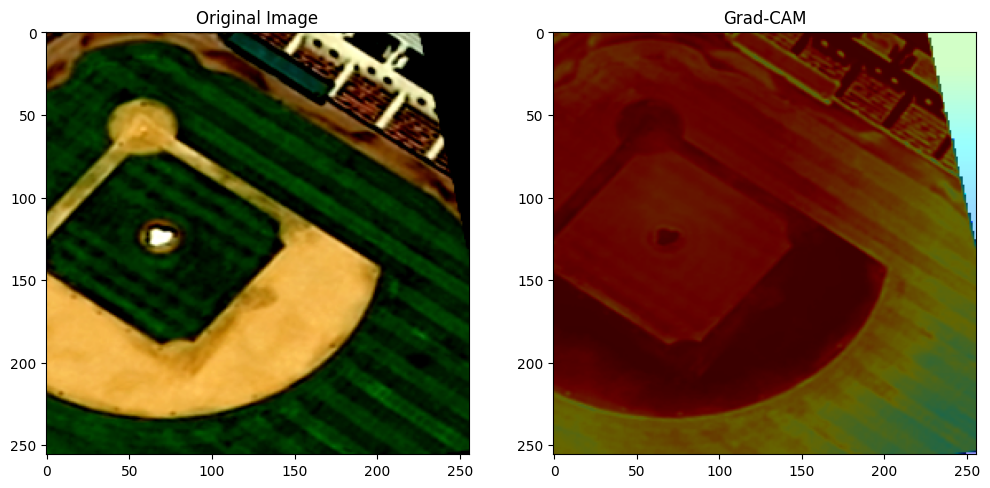

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from tf_explain.core.grad_cam import GradCAM
import joblib
import tensorflow as tf

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/baseballdiamond/baseballdiamond_000456.png"

# Load the InceptionV3 model with pre-trained weights
inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Added an extra dimension for batch size
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Get the top predicted class
# best model new is the already trained knn classifier model
predictions = best_model_new.predict(features_2D)
predicted_class = np.argmax(predictions[0])

# Create GradCAM explainer
explainer = GradCAM()

# Define a model for the InceptionV3 part
inception_model = tf.keras.models.Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.get_layer("mixed10").output)

# Compute GradCAM
grid = explainer.explain((img_array, None), inception_model, class_index=predicted_class, layer_name="mixed10")

# Apply a colormap to the single-channel image
grid_colored = cv2.applyColorMap(np.uint8(255 * grid), cv2.COLORMAP_JET)

# Convert img_array[0] to the same data type as grid_colored
img_array_colored = img_array[0].astype(grid_colored.dtype)

# Superimpose GradCAM on the original image
superimposed_img = cv2.addWeighted(img_array_colored, 0.6, grid_colored, 0.4, 0)

# Display the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM')
plt.show()

1/1 [==============================] - 2s 2s/step


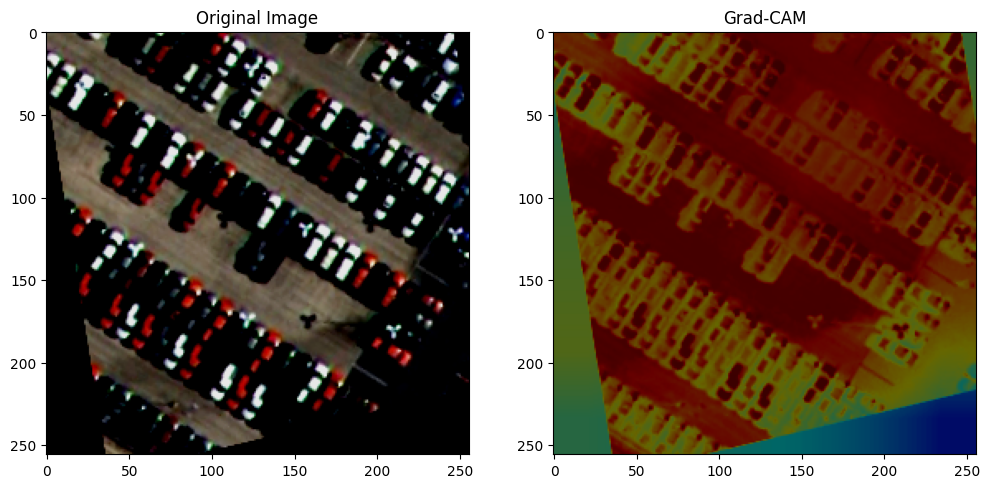

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from tf_explain.core.grad_cam import GradCAM
import joblib
import tensorflow as tf

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/parkinglot/parkinglot_000126.png"

# Load the InceptionV3 model with pre-trained weights
inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))  # Update the target_size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Get the top predicted class
predictions = best_model_new.predict(features_2D)
predicted_class = np.argmax(predictions[0])

# Create GradCAM explainer
explainer = GradCAM()

# Define a model for the InceptionV3 part
inception_model = tf.keras.models.Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.get_layer("mixed10").output)

# Compute GradCAM
grid = explainer.explain((img_array, None), inception_model, class_index=predicted_class, layer_name="mixed10")

# Apply a colormap to the single-channel image
grid_colored = cv2.applyColorMap(np.uint8(255 * grid), cv2.COLORMAP_JET)

# Convert img_array[0] to the same data type as grid_colored
img_array_colored = img_array[0].astype(grid_colored.dtype)

# Superimpose GradCAM on the original image
superimposed_img = cv2.addWeighted(img_array_colored, 0.6, grid_colored, 0.4, 0)

# Display the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM')
plt.show()

1/1 [==============================] - 2s 2s/step


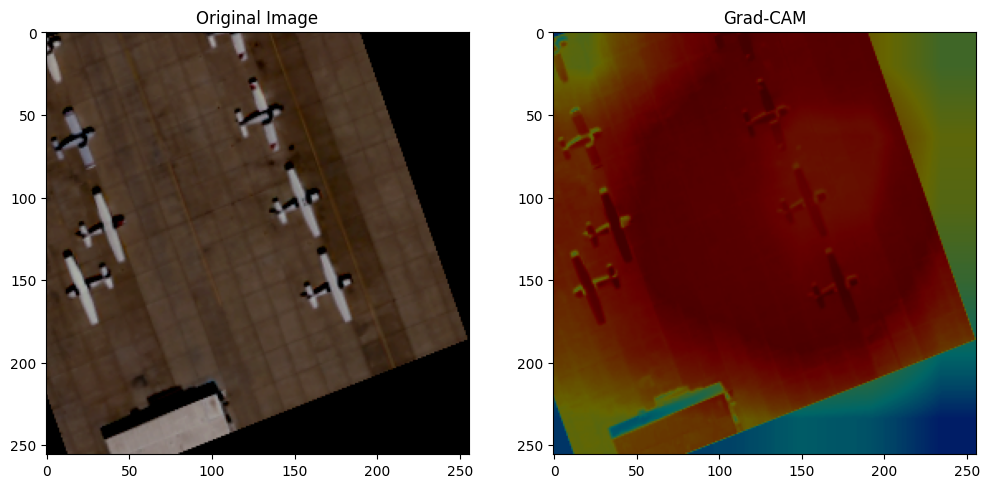

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from tf_explain.core.grad_cam import GradCAM
import joblib
import tensorflow as tf

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/airplane/airplane_000328.png"

# Load the InceptionV3 model with pre-trained weights
inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))  # Update the target_size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Get the top predicted class
predictions = best_model_new.predict(features_2D)
predicted_class = np.argmax(predictions[0])

# Create GradCAM explainer
explainer = GradCAM()

# Define a model for the InceptionV3 part
inception_model = tf.keras.models.Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.get_layer("mixed10").output)

# Compute GradCAM
grid = explainer.explain((img_array, None), inception_model, class_index=predicted_class, layer_name="mixed10")

# Apply a colormap to the single-channel image
grid_colored = cv2.applyColorMap(np.uint8(255 * grid), cv2.COLORMAP_JET)

# Convert img_array[0] to the same data type as grid_colored
img_array_colored = img_array[0].astype(grid_colored.dtype)

# Superimpose GradCAM on the original image
superimposed_img = cv2.addWeighted(img_array_colored, 0.6, grid_colored, 0.4, 0)

# Display the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM')
plt.show()

1/1 [==============================] - 1s 1s/step


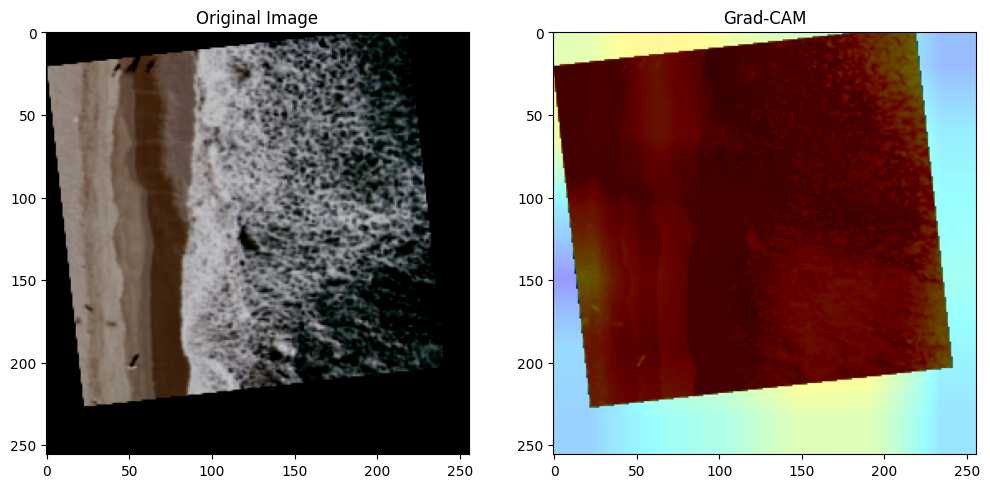

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from tf_explain.core.grad_cam import GradCAM
import joblib
import tensorflow as tf

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/beach/beach_000156.png"

# Load the InceptionV3 model with pre-trained weights
inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))  # Update the target_size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Get the top predicted class
predictions = best_model_new.predict(features_2D)
predicted_class = np.argmax(predictions[0])

# Create GradCAM explainer
explainer = GradCAM()

# Define a model for the InceptionV3 part
inception_model = tf.keras.models.Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.get_layer("mixed10").output)

# Compute GradCAM
grid = explainer.explain((img_array, None), inception_model, class_index=predicted_class, layer_name="mixed10")

# Apply a colormap to the single-channel image
grid_colored = cv2.applyColorMap(np.uint8(255 * grid), cv2.COLORMAP_JET)

# Convert img_array[0] to the same data type as grid_colored
img_array_colored = img_array[0].astype(grid_colored.dtype)

# Superimpose GradCAM on the original image
superimposed_img = cv2.addWeighted(img_array_colored, 0.6, grid_colored, 0.4, 0)

# Display the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM')
plt.show()

1/1 [==============================] - 1s 1s/step


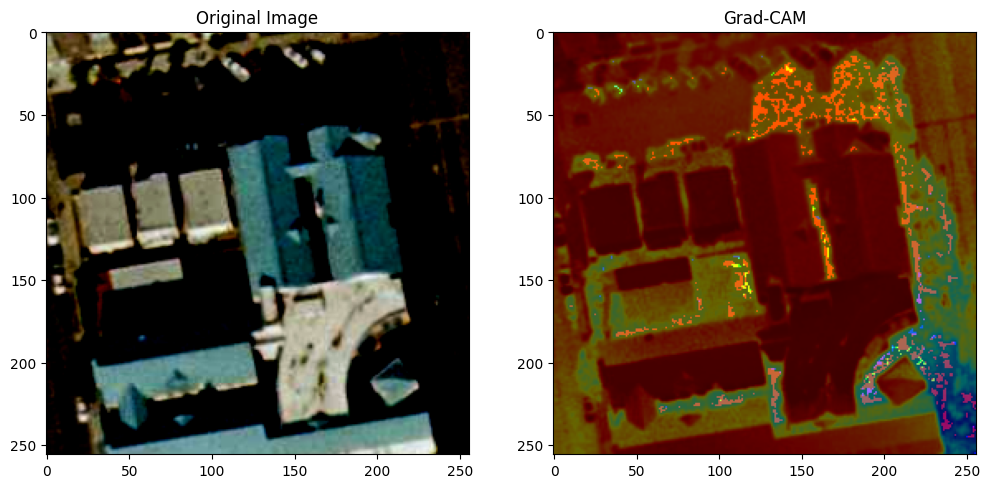

In [ ]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from tf_explain.core.grad_cam import GradCAM
import joblib
import tensorflow as tf

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/buildings/buildings_000128.png"

# Load the InceptionV3 model with pre-trained weights
inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))  # Update the target_size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Get the top predicted class
predictions = best_model_new.predict(features_2D)
predicted_class = np.argmax(predictions[0])

# Create GradCAM explainer
explainer = GradCAM()

# Define a model for the InceptionV3 part
inception_model = tf.keras.models.Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.get_layer("mixed10").output)

# Compute GradCAM
grid = explainer.explain((img_array, None), inception_model, class_index=predicted_class, layer_name="mixed10")

# Apply a colormap to the single-channel image
grid_colored = cv2.applyColorMap(np.uint8(255 * grid), cv2.COLORMAP_JET)

# Convert img_array[0] to the same data type as grid_colored
img_array_colored = img_array[0].astype(grid_colored.dtype)

# Superimpose GradCAM on the original image
superimposed_img = cv2.addWeighted(img_array_colored, 0.6, grid_colored, 0.4, 0)

# Display the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM')
plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a3d21479f8a5e460a9657d2e0dfb408db2919e2937c06087998d3781ced4d184
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


1/1 [==============================] - 2s 2s/step


  0%|          | 0/7000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


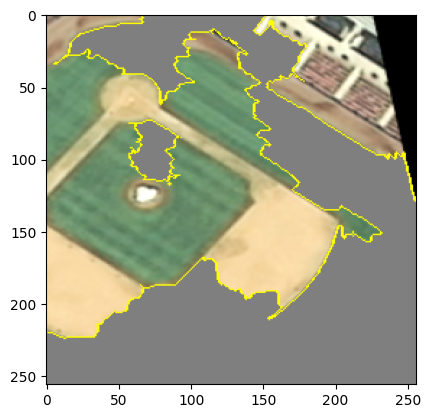

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from sklearn.neighbors import KNeighborsClassifier
from lime import lime_image
import joblib
from skimage.segmentation import mark_boundaries  # Import mark_boundaries

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/baseballdiamond/baseballdiamond_000456.png"

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Create a function that takes a 2D array as input and returns predictions
def predict_fn(images):
    # Reshape the 2D array to match the original image shape
    images_reshaped = images.reshape((images.shape[0], 256, 256, 3))

    # Preprocess the input images
    preprocessed_images = preprocess_input(images_reshaped)

    # Extract features using InceptionV3
    features = inception_v3_model.predict(preprocessed_images)

    # Reshape the features to 2D
    features_2D = features.reshape(features.shape[0], -1)

    # Use the same feature scaling and PCA as during training
    features_2D_scaled = pca_model.transform(features_2D)

    # Use the KNN model for predictions
    predictions = knn_model.predict(features_2D_scaled)

    # Convert class labels to predicted probabilities
    probabilities = np.zeros((predictions.shape[0], len(knn_model.classes_)))
    for i, label in enumerate(predictions):
        probabilities[i, label] = 1.0

    return probabilities

# Explain the prediction
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_array[0],
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=7000
)

# Display the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

1/1 [==============================] - 2s 2s/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


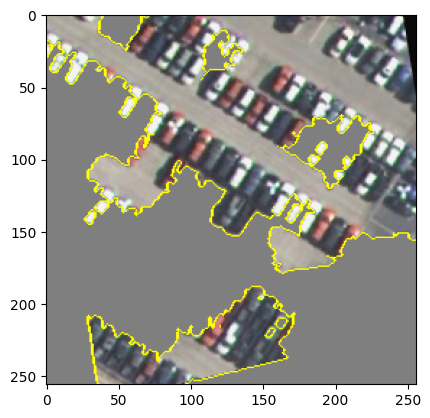

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from sklearn.neighbors import KNeighborsClassifier
from lime import lime_image
import joblib
from skimage.segmentation import mark_boundaries  # Import mark_boundaries

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/parkinglot/parkinglot_000126.png"

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Use the same feature scaling and PCA as during training
# features_2D_scaled = pca_model.transform(features_2D)

# Reshape the input features to match the original shape
# features_scaled_reshaped = features_2D_scaled.reshape(features.shape)

# Create a function that takes a 2D array as input and returns predictions
def predict_fn(images):
    # Reshape the 2D array to match the original image shape
    images_reshaped = images.reshape((images.shape[0], 256, 256, 3))

    # Preprocess the input images
    preprocessed_images = preprocess_input(images_reshaped)

    # Extract features using InceptionV3
    features = inception_v3_model.predict(preprocessed_images)

    # Reshape the features to 2D
    features_2D = features.reshape(features.shape[0], -1)

    # Use the same feature scaling and PCA as during training
    features_2D_scaled = pca_model.transform(features_2D)

    # Use the KNN model for predictions
    predictions = knn_model.predict(features_2D_scaled)

    # Convert class labels to predicted probabilities
    probabilities = np.zeros((predictions.shape[0], len(knn_model.classes_)))
    for i, label in enumerate(predictions):
        probabilities[i, label] = 1.0

    return probabilities

# Explain the prediction
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_array[0],
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=10000
)

# Display the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=25, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

1/1 [==============================] - 2s 2s/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


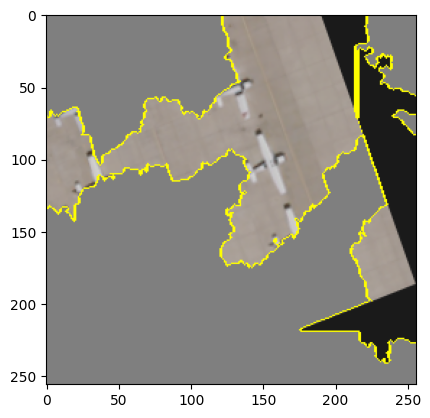

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from sklearn.neighbors import KNeighborsClassifier
from lime import lime_image
import joblib
from skimage.segmentation import mark_boundaries  # Import mark_boundaries

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/airplane/airplane_000328.png"

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Use the same feature scaling and PCA as during training
# features_2D_scaled = pca_model.transform(features_2D)

# Reshape the input features to match the original shape
# features_scaled_reshaped = features_2D_scaled.reshape(features.shape)

# Create a function that takes a 2D array as input and returns predictions
def predict_fn(images):
    # Reshape the 2D array to match the original image shape
    images_reshaped = images.reshape((images.shape[0], 256, 256, 3))

    # Preprocess the input images
    preprocessed_images = preprocess_input(images_reshaped)

    # Extract features using InceptionV3
    features = inception_v3_model.predict(preprocessed_images)

    # Reshape the features to 2D
    features_2D = features.reshape(features.shape[0], -1)

    # Use the same feature scaling and PCA as during training
    features_2D_scaled = pca_model.transform(features_2D)

    # Use the KNN model for predictions
    predictions = knn_model.predict(features_2D_scaled)

    # Convert class labels to predicted probabilities
    probabilities = np.zeros((predictions.shape[0], len(knn_model.classes_)))
    for i, label in enumerate(predictions):
        probabilities[i, label] = 1.0

    return probabilities

# Explain the prediction
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_array[0],
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=10000
)

# Display the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=25, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

1/1 [==============================] - 1s 1s/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


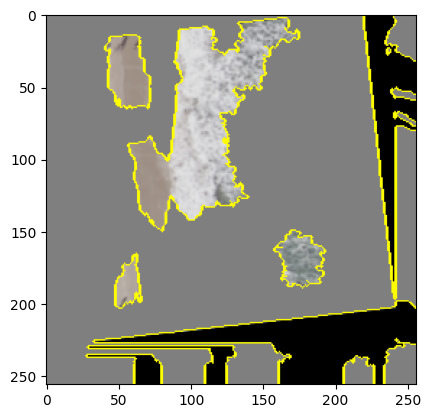

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from sklearn.neighbors import KNeighborsClassifier
from lime import lime_image
import joblib
from skimage.segmentation import mark_boundaries  # Import mark_boundaries

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/beach/beach_000156.png"

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Use the same feature scaling and PCA as during training
# features_2D_scaled = pca_model.transform(features_2D)

# Reshape the input features to match the original shape
# features_scaled_reshaped = features_2D_scaled.reshape(features.shape)

# Create a function that takes a 2D array as input and returns predictions
def predict_fn(images):
    # Reshape the 2D array to match the original image shape
    images_reshaped = images.reshape((images.shape[0], 256, 256, 3))

    # Preprocess the input images
    preprocessed_images = preprocess_input(images_reshaped)

    # Extract features using InceptionV3
    features = inception_v3_model.predict(preprocessed_images)

    # Reshape the features to 2D
    features_2D = features.reshape(features.shape[0], -1)

    # Use the same feature scaling and PCA as during training
    features_2D_scaled = pca_model.transform(features_2D)

    # Use the KNN model for predictions
    predictions = knn_model.predict(features_2D_scaled)

    # Convert class labels to predicted probabilities
    probabilities = np.zeros((predictions.shape[0], len(knn_model.classes_)))
    for i, label in enumerate(predictions):
        probabilities[i, label] = 1.0

    return probabilities

# Explain the prediction
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_array[0],
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=10000
)

# Display the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=25, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

1/1 [==============================] - 2s 2s/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


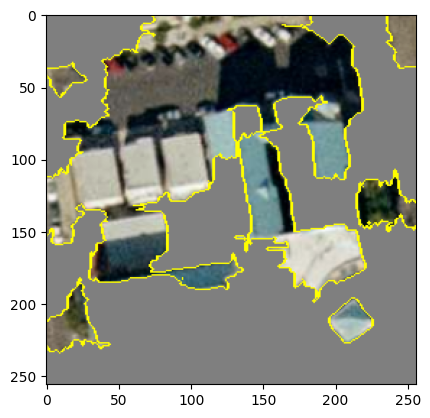

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from sklearn.neighbors import KNeighborsClassifier
from lime import lime_image
import joblib
from skimage.segmentation import mark_boundaries  # Import mark_boundaries

# Load the trained KNN model
model_save_path = '/content/drive/My Drive/CNN_KNN_best_model/best_model_new.joblib'
best_model_new = joblib.load(model_save_path)

inception_v3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Choose an image from your test set for visualization
test_img_path = "/content/landuse-scene-classification/images_train_test_val/test/buildings/buildings_000128.png"

# Preprocess the input image
img = image.load_img(test_img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Extract features using the InceptionV3 model
features = inception_v3_model.predict(img_array)

# Reshape the features to 2D
features_2D = features.reshape(features.shape[0], -1)

# Use the same feature scaling and PCA as during training
# features_2D_scaled = pca_model.transform(features_2D)

# Reshape the input features to match the original shape
# features_scaled_reshaped = features_2D_scaled.reshape(features.shape)

# Create a function that takes a 2D array as input and returns predictions
def predict_fn(images):
    # Reshape the 2D array to match the original image shape
    images_reshaped = images.reshape((images.shape[0], 256, 256, 3))

    # Preprocess the input images
    preprocessed_images = preprocess_input(images_reshaped)

    # Extract features using InceptionV3
    features = inception_v3_model.predict(preprocessed_images)

    # Reshape the features to 2D
    features_2D = features.reshape(features.shape[0], -1)

    # Use the same feature scaling and PCA as during training
    features_2D_scaled = pca_model.transform(features_2D)

    # Use the KNN model for predictions
    predictions = knn_model.predict(features_2D_scaled)

    # Convert class labels to predicted probabilities
    probabilities = np.zeros((predictions.shape[0], len(knn_model.classes_)))
    for i, label in enumerate(predictions):
        probabilities[i, label] = 1.0

    return probabilities

# Explain the prediction
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_array[0],
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=10000
)

# Display the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=25, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

In [ ]:
pca_model

PCA(n_components=100)

In [ ]:
knn_model

KNeighborsClassifier(n_neighbors=11)

In [ ]:
img_array.shape

(1, 256, 256, 3)

In [ ]:
features_2D.shape

(1, 73728)

In [ ]:
features_2D_scaled.shape

(1, 100)

In [ ]:
img_array[0].shape

(256, 256, 3)